In [1]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from matplotlib import pyplot as plt

In [2]:
batch_size=64 #批次大小
img_size=28 #图片尺寸

def get_dataloader(bo=True):
    '''
    bo控制该dataloder为训练loader还是测试loader
    '''
    
    dataset=torchvision.datasets.MNIST("/data",train=bo,download=True,transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,),(0.3081,)),]))#归一化处理，防止数据过拟合，0.1307是该数据集的均值，0.3081是该数据集的标准差
    

    dataloader=torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=batch_size,drop_last=True)
    
    return dataloader

In [3]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        # super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)  # 灰度图片的通道，输出通道，卷积核大小
        self.conv2 = nn.Conv2d(10, 20, 3)
        #构建全连接层
        self.fc1=nn.Linear(20*10*10,64)
        self.fc2=nn.Linear(64,10)

    def forward(self,x):
        input_size = x.size(0)
        x=self.conv1(x) #使用self.conv1对x进行第一次卷积操作，得到32个特征图
        x=F.relu(x) #然后使用F.rule函数对特征图进行激活
        x =F.max_pool2d(x,2,2) #使用F.max_pool2d对激活后的特征图进行最大池化操作，池化窗口大小为2*2，步长也为2，这样可以降低特征图的维度，减少计算量

        x =self.conv2(x) #使用self.conv2对池化后的特征图进行第二次卷积操作，得到64个特征图
        x =F.relu(x) #使用torch.nn.F.relu函数对特征图进行激活

        # x=np.reshape(x,64,2000)
        x = x.view(64,-1)# 使用x.view函数对激活后的特征图进行展平操作，将其转化为一维向量，方便后续的全连接层处理，这里的20*10*10表示展平后的向量长度
        x=self.fc1(x) #使用self.fc1对展平后的向量进行第一次全连接操作，得到一个长度为128的向量
        x=F.relu(x) #使用F.relu函数对向量进行激活
        x=self.fc2(x) #使用self.fc2对激活后的向量进行第二次全连接操作，得到一个长度为10的向量，这个向量表示输出层的预测结果，每个元素对应一个类别的概率
        out= F.log_softmax(x,dim=-1)   #使用F.log_softmax函数对输出层的向量进行对数softmax操作，得到一个长度为10的向量，每个元素表示一个类别的对数概率，这样可以方便后续的交叉熵损失函数计算
        #输出层激活
        return  out
        

In [4]:
#训练loader
train_dataloader=get_dataloader(True)
#测试loader
test_loader=get_dataloader(False)

In [5]:
model = net()

criterion =nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr学习率

train_loss_list=[]

In [6]:
#训练
def train(epoch):
    model.train(True)
    
    for idx,(data,target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)#对数似然损失
        loss.backward()
        optimizer.step()
        if idx%10==0:
            train_loss_list.append(loss.item())
            if idx%200==0:
                print( 'Train Epoch:{} [{}/{} ({:.8f}%)]\tLoss:{:.8f}'.format (epoch+1,idx * len(data),len (train_dataloader.dataset),100.*idx * len(data)/len (train_dataloader.dataset),loss))


In [7]:
#开始训练，可调整epoch来改变训练次数
epoch=5
for i in range(epoch):
    train(i)

Train Epoch:1 [0/60000 (0.00000000%)]	Loss:2.31854534
Train Epoch:1 [12800/60000 (21.33333333%)]	Loss:0.31424215
Train Epoch:1 [25600/60000 (42.66666667%)]	Loss:0.07969587
Train Epoch:1 [38400/60000 (64.00000000%)]	Loss:0.06176901
Train Epoch:1 [51200/60000 (85.33333333%)]	Loss:0.02558265
Train Epoch:2 [0/60000 (0.00000000%)]	Loss:0.11255001
Train Epoch:2 [12800/60000 (21.33333333%)]	Loss:0.05873564
Train Epoch:2 [25600/60000 (42.66666667%)]	Loss:0.02094891
Train Epoch:2 [38400/60000 (64.00000000%)]	Loss:0.02782098
Train Epoch:2 [51200/60000 (85.33333333%)]	Loss:0.04210689
Train Epoch:3 [0/60000 (0.00000000%)]	Loss:0.01216218
Train Epoch:3 [12800/60000 (21.33333333%)]	Loss:0.05973772
Train Epoch:3 [25600/60000 (42.66666667%)]	Loss:0.00661978
Train Epoch:3 [38400/60000 (64.00000000%)]	Loss:0.01508698
Train Epoch:3 [51200/60000 (85.33333333%)]	Loss:0.04655940
Train Epoch:4 [0/60000 (0.00000000%)]	Loss:0.03004076
Train Epoch:4 [12800/60000 (21.33333333%)]	Loss:0.00713614
Train Epoch:4 [25

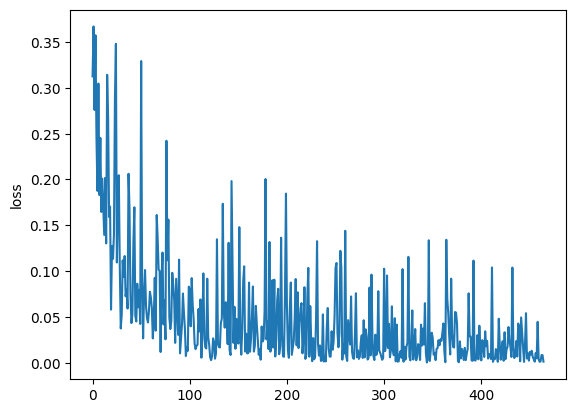

In [8]:
#画图
def fig(lst):
    plt.figure()
    plt.plot(range(len(lst[5:])),lst[5:])

    plt.ylabel("loss")
    plt.show()

fig(train_loss_list)

In [9]:
#测试评估
def test():
    test_loss=0
    correct=0;
    model.eval()

    with torch.no_grad():
        for data,target in test_loader:
            output=model(data)
            test_loss+=F.nll_loss(output,target,reduction="sum").item()
            pred=output.data.max(1,keepdim=True)[1]
            correct+=pred.eq(target.data.view_as(pred)).sum()
            test_loss/=len(test_loader.dataset)
            print("\nTest: loss:{:.8f},accuracy:{}/{} ({:.2f}%)\n".format(test_loss,correct,len(test_loader.dataset),100.*correct/len(test_loader.dataset)))
    

In [11]:

test()


Test: loss:0.00005606,accuracy:64/10000 (0.64%)


Test: loss:0.00005745,accuracy:128/10000 (1.28%)


Test: loss:0.00019090,accuracy:191/10000 (1.91%)


Test: loss:0.00014820,accuracy:254/10000 (2.54%)


Test: loss:0.00010905,accuracy:318/10000 (3.18%)


Test: loss:0.00004183,accuracy:382/10000 (3.82%)


Test: loss:0.00002514,accuracy:446/10000 (4.46%)


Test: loss:0.00023016,accuracy:509/10000 (5.09%)


Test: loss:0.00006660,accuracy:573/10000 (5.73%)


Test: loss:0.00050183,accuracy:636/10000 (6.36%)


Test: loss:0.00009385,accuracy:700/10000 (7.00%)


Test: loss:0.00009253,accuracy:763/10000 (7.63%)


Test: loss:0.00001743,accuracy:827/10000 (8.27%)


Test: loss:0.00001405,accuracy:891/10000 (8.91%)


Test: loss:0.00047270,accuracy:954/10000 (9.54%)


Test: loss:0.00000938,accuracy:1018/10000 (10.18%)


Test: loss:0.00004441,accuracy:1082/10000 (10.82%)


Test: loss:0.00012283,accuracy:1146/10000 (11.46%)


Test: loss:0.00000905,accuracy:1210/10000 (12.10%)


Test: loss:0.00089683,a